## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
train = pd.read_csv("data/train.csv")
test= pd.read_csv("data/test.csv")

In [20]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [21]:
train.drop('id', axis=1, inplace=True);
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [11]:
train.dtypes

id                                        int64
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                         int64
required_car_parking_space                int64
room_type_reserved                        int64
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                       int64
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                            int64
dtype: object

In [22]:
train.shape

(42100, 18)

<AxesSubplot: >

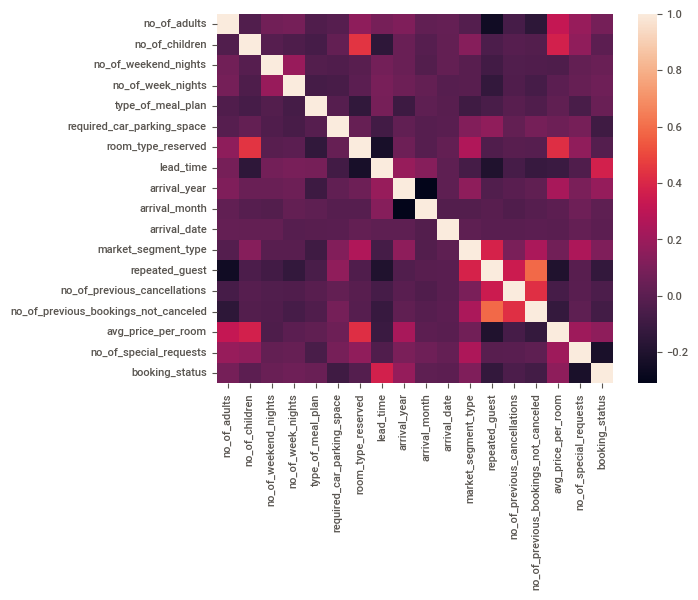

In [27]:
corrMatrix = train.corr()
sns.heatmap(corrMatrix)


In [6]:
! pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 5.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.3 MB/s eta 0:00:00


In [7]:
import sweetviz as sv

/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
# Let use sweetviz tool to explore the data

my_report = sv.analyze(train)
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: no_of_adults                        |  | [  5%]   00:00 -> (00:00 left)/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: no_of_children                      |▏ | [ 11%]   00:00 -> (00:00

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Relation betweet target and features

#### Variable strategy:
* Numerical : 

In [33]:
# Features strategy: 

categorical = [
    'no_of_adults', # One hot encoding
    'no_of_children',  # One hot encoding
    'no_of_week_nights',  # One hot encoding, maybe new variable no_of_nights
    'no_of_weekend_nights',  # One hot encoding
    'type_of_meal_plan',  # One hot encoding
    'required_car_parking_space',# Binary, no need of One hot encoding
    'room_type_reserved', # One hot enconding
    'market_segment_type', # One hot encoding
    'repeated_guest', # Binary, no need of One hot encoding
    'no_of_special_requests',  # One hot encoding
      
]
numerical = ['avg_price_per_room', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled']

seasonal = [
    'arrival_date', # Crate a seasonal sinuoidal feature mixing date (day of the month) ,  month
    'arrival_month',# covered above 
    'arrival_year', # One hot encode
    
]

# ToDo 
* explore lead_time to further undertand what is it
* create seasonal feature
* E.D.A see how each feature affect the target, including seasonal feature (to check if there is a seasonality)
* ML basic
* ML with feature engineenring